# <center> Предсказание пола клиента </center>

### Необходимо выявить пол клиента, основываясь на его транзакционных исторических данных. В роли метрики качества выступает [ROC AUC](https://dyakonov.org/2017/07/28/auc-roc-%D0%BF%D0%BB%D0%BE%D1%89%D0%B0%D0%B4%D1%8C-%D0%BF%D0%BE%D0%B4-%D0%BA%D1%80%D0%B8%D0%B2%D0%BE%D0%B9-%D0%BE%D1%88%D0%B8%D0%B1%D0%BE%D0%BA/), который и нужно будет максимизировать.

## Описание файлов
- transactions.csv - исторические транзакции банковских клиентов
- gender.csv - информация по полу для части клиентов (null - для тестовых)
- tr_mcc_codes.csv - mcc-коды транзакций
- tr_types.csv - типы транзакций

## Описание полей
### transactions.csv
- customer_id - идентификатор клиента
- tr_datetime - день и время совершения транзакции (дни нумеруются с начала данных)
- mcc_code - mcc-код транзакции
- tr_type - тип транзакции
- amount - сумма транзакции в условных единицах; со знаком "+" — начисление средств клиенту, "-" — списание средств
- term_id - идентификатор терминала

### gender.csv
- customer_id - идентификатор клиента
- gender - пол клиента (пустые значения - тестовые клиенты)

### tr_mcc_codes.csv
- mcc_code - mcc-код транзакции
- mcc_description - описание mcc-кода транзакции

### tr_types.csv
- tr_type - тип транзакции
- tr_description - описание типа транзакции

## Задачи:
- Разработать модель бинарной классификации для определения пола клиента. Никаких ограничений к модели - может быть что угодно от KNN до трансформеров. Главное, чтобы ROC AUC на отложенном тесте получился выше 77.5%.
- Интерпретировать результаты модели: важность входящих в нее переменных, демонстрация на нескольких примерах, почему получился соответствующий прогноз. Последнее позволит понять, какой пол к какому из таргетов (0/1) принадлежит. Опять же, полная свобода выбора подходов! Полезные ключевые слова: gain, permutation importance, SHAP.
- Конвертировать результаты в отчет без кода (идеально - напрямую в [html](https://stackoverflow.com/questions/49907455/hide-code-when-exporting-jupyter-notebook-to-html))

#### P.S. Не забываем про [PEP8](https://www.python.org/dev/peps/pep-0008/)!

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
import numpy as np
import pandas as pd

In [3]:
tr_mcc_codes = pd.read_csv("/content/drive/MyDrive/data/tr_mcc_codes.csv", sep=";", index_col="mcc_code")
tr_types = pd.read_csv("/content/drive/MyDrive/data/tr_types.csv", sep=";", index_col="tr_type")

transactions = pd.read_csv("/content/drive/MyDrive/data/transactions.csv")
gender = pd.read_csv("/content/drive/MyDrive/data/gender.csv", index_col="customer_id")

In [4]:
# Объединение данных по идентификатору клиента
merged_df = pd.merge(transactions, gender, on="customer_id", how="left")

In [5]:
# Объединение данных по mcc_code
merged_df = pd.merge(merged_df, tr_mcc_codes, on="mcc_code", how="left")

In [6]:
# Объединение данных по tr_type
merged_df = pd.merge(merged_df, tr_types, on="tr_type", how="left")

In [7]:
merged_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 6849346 entries, 0 to 6849345
Data columns (total 9 columns):
 #   Column           Dtype  
---  ------           -----  
 0   customer_id      int64  
 1   tr_datetime      object 
 2   mcc_code         int64  
 3   tr_type          int64  
 4   amount           float64
 5   term_id          object 
 6   gender           float64
 7   mcc_description  object 
 8   tr_description   object 
dtypes: float64(2), int64(3), object(4)
memory usage: 522.6+ MB


In [31]:
# Замена значений NaN на 'не определено' в столбце 'gender'
merged_df['gender'].fillna('не определено', inplace=True)

In [8]:
# Вычисляем длину каждой строки в столбце mcc_description
lengths = merged_df['mcc_description'].str.len()

# Средняя длина
average_length = lengths.mean()

# Максимальная длина
max_length = lengths.max()

print("Средняя длина в столбце mcc_description:", average_length)
print("Максимальная длина в столбце mcc_description:", max_length)


Средняя длина в столбце mcc_description: 47.74076824269061
Максимальная длина в столбце mcc_description: 154


In [9]:
# Обрезаем значения в столбце mcc_description до 50 символов
merged_df['mcc_description'] = merged_df['mcc_description'].str.slice(0, 50)

In [10]:
# Группируем данные по MCC кодам и их описанию, считая количество транзакций
mcc_counts = merged_df.groupby(['mcc_code', 'mcc_description']).size()

# Сортируем MCC коды по общему количеству транзакций и выбираем топ-20
top_mcc_codes = mcc_counts.sort_values(ascending=False).head(20)

# Выводим результаты
print("Топ 20 MCC кодов с их описанием:")
print(top_mcc_codes)




Топ 20 MCC кодов с их описанием:
mcc_code  mcc_description                                   
6011      Финансовые институты — снятие наличности автоматич    1447370
6010      Финансовые институты — снятие наличности вручную      1021046
4814      Звонки с использованием телефонов, считывающих маг     987181
5411      Бакалейные магазины, супермаркеты                      961860
4829      Денежные переводы                                      624643
5499      Различные продовольственные магазины — рынки, мага     336014
5541      Станции техобслуживания                                141825
5912      Аптеки                                                 134031
5331      Универсальные магазины                                 127890
5812      Места общественного питания, рестораны                 106854
5814      Рестораны, закусочные                                   96839
5921      Магазины с продажей спиртных напитков на вынос (пи      58705
5999      Плавательные бассейны — распрода

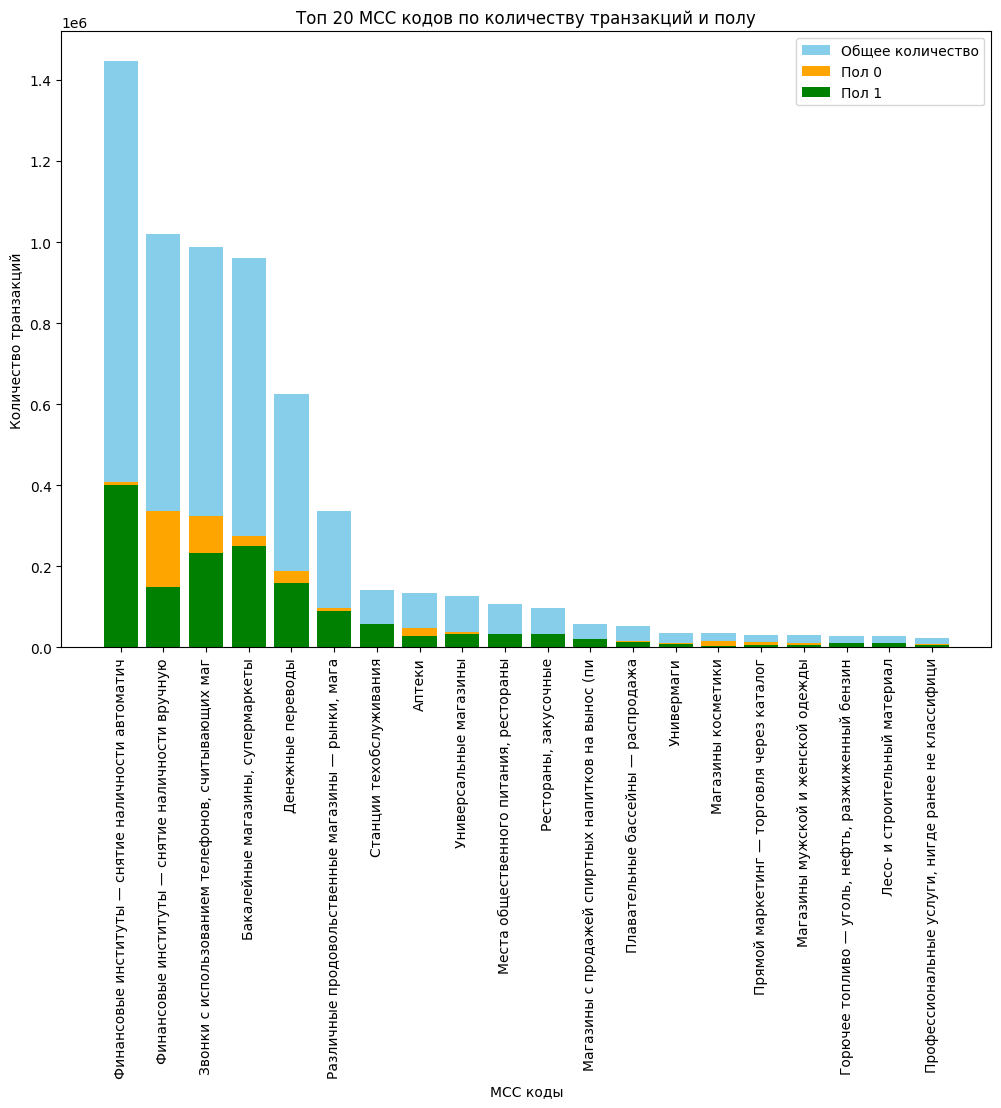

In [32]:
import matplotlib.pyplot as plt
# Создание DataFrame с топ-20 MCC кодами и их описаниями
top_mcc_codes_df = merged_df.groupby(['mcc_code', 'mcc_description']).size().sort_values(ascending=False).head(20).reset_index(name='count')

gender_info = merged_df.groupby(['mcc_code', 'mcc_description', 'gender']).size().unstack()
gender_info = gender_info.loc[top_mcc_codes_df['mcc_code']]  # Фильтрация только для топ-20 MCC кодов



# Построение графика
plt.figure(figsize=(12, 8))
for index, row in top_mcc_codes_df.iterrows():
    mcc_description = row['mcc_description']
    mcc_code = row['mcc_code']
    count = row['count']
    gender_0 = gender_info.loc[mcc_code, 0]
    gender_1 = gender_info.loc[mcc_code, 1]
    plt.bar(mcc_description, count, color='skyblue')
    plt.bar(mcc_description, gender_0, color='orange')
    plt.bar(mcc_description, gender_1, color='green')

plt.title('Топ 20 MCC кодов по количеству транзакций и полу')
plt.xlabel('MCC коды')
plt.ylabel('Количество транзакций')
plt.xticks(rotation=90)
plt.legend(['Общее количество', 'Пол 0', 'Пол 1'])
plt.show()


In [33]:
# Подсчет уникальных значений в столбцах
unique_customer_id = merged_df['customer_id'].nunique()
unique_mcc_code = merged_df['mcc_code'].nunique()
unique_tr_type = merged_df['tr_type'].nunique()
unique_gender = merged_df['gender'].nunique()

# Вывод результатов
print(f"Уникальных значений в столбце 'customer_id': {unique_customer_id}")
print(f"Уникальных значений в столбце 'mcc_code': {unique_mcc_code}")
print(f"Уникальных значений в столбце 'tr_type': {unique_tr_type}")
print(f"Уникальных значений в столбце 'gender': {unique_gender}")

Уникальных значений в столбце 'customer_id': 15000
Уникальных значений в столбце 'mcc_code': 184
Уникальных значений в столбце 'tr_type': 77
Уникальных значений в столбце 'gender': 3


In [15]:
unique_mcc_info = merged_df[['mcc_code', 'mcc_description']].drop_duplicates()
print(unique_mcc_info)


        mcc_code                                    mcc_description
0           4814  Звонки с использованием телефонов, считывающих...
1           6011  Финансовые институты — снятие наличности автом...
2           4829                                  Денежные переводы
3           5499  Различные продовольственные магазины — рынки, ...
5           5541                            Станции техобслуживания
...          ...                                                ...
232443      9402             Почтовые услуги — только правительство
247481      5697       Услуги по переделке, починке и пошиву одежды
536655      1731                        Подрядчики по электричеству
561945      5940              Веломагазины — продажа и обслуживание
909029      9211  Судовые выплаты, включая алименты и детскую по...

[184 rows x 2 columns]


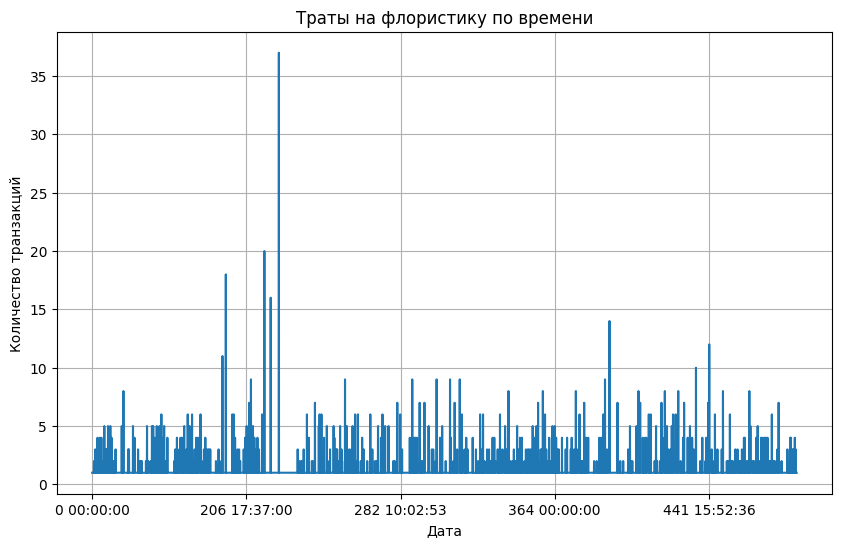

In [16]:
import matplotlib.pyplot as plt

# Выбираем только строки с тратами на флористику
floristics_transactions = merged_df[merged_df['mcc_description'] == 'Флористика']

# Подсчитываем количество транзакций на флористику по дням/месяцам/годам или другим временным отрезкам
# Например, если у вас столбец 'tr_datetime' содержит даты и время транзакций, вы можете использовать его
transactions_count_by_date = floristics_transactions.groupby('tr_datetime').size()

# Построение графика
plt.figure(figsize=(10, 6))
transactions_count_by_date.plot()
plt.title('Траты на флористику по времени')
plt.xlabel('Дата')
plt.ylabel('Количество транзакций')
plt.grid(True)
plt.show()


In [17]:
# Находим день с максимальным количеством транзакций
max_transactions_day = transactions_count_by_date.idxmax()

# Выводим день, в который было максимальное количество транзакций
print("День с максимальным количеством транзакций на флористику:", max_transactions_day)


День с максимальным количеством транзакций на флористику: 219 00:00:00


In [18]:
from datetime import datetime, timedelta

# Задаем исходную дату
start_date = datetime(2023, 3, 8)

# Вычитаем 219 дней
result_date = start_date - timedelta(days=219)

# Выводим результат
print("Дата после вычитания 219 дней:", result_date.strftime('%d.%m.%Y'))


Дата после вычитания 219 дней: 01.08.2022


In [19]:
# Преобразование номера дня в дату по итогам эмпирического исследования
start_date = pd.to_datetime('2022-08-01')  # Установка начальной даты

# Добавление столбца с датой
merged_df['date'] = start_date + pd.to_timedelta(merged_df['tr_datetime'].str.split(' ').str[0].astype(int), unit='D')

# Добавление столбца с временем
merged_df['time'] = pd.to_datetime(merged_df['tr_datetime'].str.split(' ').str[1], format='%H:%M:%S').dt.time

In [20]:
# Отображение результатов
print(merged_df[['date', 'time']])

              date      time
0       2022-08-01  10:23:26
1       2022-08-02  10:19:29
2       2022-08-02  10:20:56
3       2022-08-02  10:39:54
4       2022-08-03  15:33:42
...            ...       ...
6849341 2023-10-28  16:03:02
6849342 2023-10-29  10:55:00
6849343 2023-10-29  14:23:59
6849344 2023-10-29  16:11:53
6849345 2023-10-29  18:06:30

[6849346 rows x 2 columns]


In [21]:
merged_df = merged_df.drop(['tr_datetime', 'tr_description', 'time'], axis=1)
merged_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 6849346 entries, 0 to 6849345
Data columns (total 8 columns):
 #   Column           Dtype         
---  ------           -----         
 0   customer_id      int64         
 1   mcc_code         int64         
 2   tr_type          int64         
 3   amount           float64       
 4   term_id          object        
 5   gender           float64       
 6   mcc_description  object        
 7   date             datetime64[ns]
dtypes: datetime64[ns](1), float64(2), int64(3), object(2)
memory usage: 470.3+ MB


In [23]:
mcc_description_dict = {
    5411: 'Grocery Stores, Supermarkets',
    4829: 'Money Transfers',
    5499: 'Various Grocery Stores',
    5541: 'Service Stations',
    5912: 'Pharmacies',
    5331: 'Department Stores',
    5812: 'Eating Places, Restaurants',
    5814: 'Fast Food Restaurants',
    5921: 'Liquor Stores',
    5999: 'Swimming Pools - Sales',
    5311: 'Department Stores',
    5977: 'Cosmetic Stores',
    5964: 'Direct Marketing - Catalog Merchants',
    5691: 'Clothing Stores',
    5983: 'Fuel - Coal, Fuel Oil, Wood',
    5211: 'Lumber, Building Materials Stores',
    8999: 'Professional Services, Not Elsewhere Classified'
}


In [34]:
#  Агрегация данных по клиентам
aggregated_data = merged_df.groupby('customer_id').agg({
    'amount': ['sum', 'mean', 'std'],  # Сумма, среднее и стандартное отклонение суммы транзакций
    'mcc_code': 'nunique',             # Количество уникальных MCC-кодов
    'tr_type': 'nunique',              # Количество уникальных типов транзакций
    'gender': 'first'                  # Пол клиента (первое значение)
})

# Переименование столбцов для удобства
aggregated_data.columns = ['total_amount', 'mean_amount', 'std_amount', 'unique_mcc_codes', 'unique_tr_types', 'gender']

# aggregated_data = aggregated_data.reset_index()



In [35]:
# Создаем столбцы для каждого MCC кода и заполняем их значениями на основе количества использований кода MCC для каждого клиента
for mcc_code, mcc_description in mcc_description_dict.items():
    aggregated_data[mcc_description] = merged_df[merged_df['mcc_code'] == mcc_code].groupby('customer_id').size()
    aggregated_data[mcc_description].fillna(0, inplace=True)  # Заменяем отсутствующие значения на 0



In [36]:
aggregated_data

,total_amount,mean_amount,std_amount,unique_mcc_codes,unique_tr_types,gender,"Grocery Stores, Supermarkets",Money Transfers,Various Grocery Stores,Service Stations,...,"Eating Places, Restaurants",Fast Food Restaurants,Liquor Stores,Swimming Pools - Sales,Cosmetic Stores,Direct Marketing - Catalog Merchants,Clothing Stores,"Fuel - Coal, Fuel Oil, Wood","Lumber, Building Materials Stores","Professional Services, Not Elsewhere Classified"
customer_id,,,,,,,,,,,,,,,,,,,,,
6815,-1249454.87,-5528.561372,1.683710e+05,6,6,не определено,29.0,0.0,0.0,0.0,...,0.0,0.0,2.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
22899,-629796.59,-2691.438419,1.278516e+05,11,21,1.0,6.0,27.0,15.0,8.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
27914,-2977026.82,-26820.061441,1.046751e+05,6,7,1.0,0.0,3.0,0.0,1.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
28753,-26546282.86,-90293.479116,7.855862e+05,30,15,0.0,20.0,33.0,2.0,6.0,...,0.0,54.0,0.0,13.0,1.0,0.0,2.0,0.0,2.0,2.0
31385,-2180003.58,-5972.612548,3.341856e+04,17,17,0.0,126.0,2.0,3.0,0.0,...,0.0,1.0,0.0,7.0,1.0,0.0,4.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
99984336,-8196354.85,-130100.870635,2.319028e+05,5,5,не определено,1.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
99985917,331115.38,16555.769000,1.084380e+06,5,6,не определено,1.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
99988578,-11154687.43,-13504.464201,8.017118e+04,28,18,1.0,147.0,113.0,77.0,4.0,...,2.0,9.0,2.0,0.0,2.0,0.0,4.0,0.0,2.0,31.0


In [37]:
aggregated_data['std_amount'].fillna(0, inplace=True)

In [39]:
aggregated_data['gender'].nunique()

3

In [40]:
aggregated_data.shape

(15000, 22)

In [41]:
# Агрегация средней суммы транзакций в день
mean_amount_daily = merged_df.groupby(['customer_id', 'date'])['amount'].mean()
aggregated_data['mean_amount_daily'] = mean_amount_daily.groupby('customer_id').mean()

# Агрегация максимальной суммы транзакции в день
max_amount_daily = merged_df.groupby(['customer_id', 'date'])['amount'].max()
aggregated_data['max_amount_daily'] = max_amount_daily.groupby('customer_id').max()



In [42]:

aggregated_data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 15000 entries, 6815 to 99999680
Data columns (total 24 columns):
 #   Column                                           Non-Null Count  Dtype  
---  ------                                           --------------  -----  
 0   total_amount                                     15000 non-null  float64
 1   mean_amount                                      15000 non-null  float64
 2   std_amount                                       15000 non-null  float64
 3   unique_mcc_codes                                 15000 non-null  int64  
 4   unique_tr_types                                  15000 non-null  int64  
 5   gender                                           15000 non-null  object 
 6   Grocery Stores, Supermarkets                     15000 non-null  float64
 7   Money Transfers                                  15000 non-null  float64
 8   Various Grocery Stores                           15000 non-null  float64
 9   Service Stations      

In [43]:
file_path = "aggregated_datafin.csv"

# Сохраните DataFrame в формате CSV
aggregated_data.reset_index().to_csv(file_path, index=False)

In [ ]:
aggregated_data = pd.read_csv('/content/drive/MyDrive/aggregated_datafin.csv')

In [44]:
aggregated_data.head(3)

,total_amount,mean_amount,std_amount,unique_mcc_codes,unique_tr_types,gender,"Grocery Stores, Supermarkets",Money Transfers,Various Grocery Stores,Service Stations,...,Liquor Stores,Swimming Pools - Sales,Cosmetic Stores,Direct Marketing - Catalog Merchants,Clothing Stores,"Fuel - Coal, Fuel Oil, Wood","Lumber, Building Materials Stores","Professional Services, Not Elsewhere Classified",mean_amount_daily,max_amount_daily
customer_id,,,,,,,,,,,,,,,,,,,,,
6815,-1249454.87,-5528.561372,168370.985787,6,6,не определено,29.0,0.0,0.0,0.0,...,2.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,143.833884,2470507.35
22899,-629796.59,-2691.438419,127851.642622,11,21,1.0,6.0,27.0,15.0,8.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,-1757.677167,875907.15
27914,-2977026.82,-26820.061441,104675.148673,6,7,1.0,0.0,3.0,0.0,1.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,-42086.108434,89836.63


In [45]:
# Выделение тестовой выборки, где gender равен 'не определено'
test_data = aggregated_data[aggregated_data['gender'] == 'не определено']

# Выделение обучающей выборки, где gender не равен 'не определено'
train_data = aggregated_data[aggregated_data['gender'] != 'не определено']

# Проверка размеров обучающей и тестовой выборок
print("Train data shape:", train_data.shape)
print("Test data shape:", test_data.shape)


Train data shape: (8400, 24)
Test data shape: (6600, 24)


In [47]:
gender_counts = aggregated_data['gender'].value_counts()
gender_counts

не определено    6600
0.0              4651
1.0              3749
Name: gender, dtype: int64

In [48]:
#  Определение признаков и целевой переменной
X = train_data.drop('gender', axis=1)
y = train_data['gender']


In [52]:
X.head(3)

,total_amount,mean_amount,std_amount,unique_mcc_codes,unique_tr_types,"Grocery Stores, Supermarkets",Money Transfers,Various Grocery Stores,Service Stations,Pharmacies,...,Liquor Stores,Swimming Pools - Sales,Cosmetic Stores,Direct Marketing - Catalog Merchants,Clothing Stores,"Fuel - Coal, Fuel Oil, Wood","Lumber, Building Materials Stores","Professional Services, Not Elsewhere Classified",mean_amount_daily,max_amount_daily
customer_id,,,,,,,,,,,,,,,,,,,,,
22899,-629796.59,-2691.438419,127851.642622,11,21,6.0,27.0,15.0,8.0,1.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,-1757.677167,875907.15
27914,-2977026.82,-26820.061441,104675.148673,6,7,0.0,3.0,0.0,1.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,-42086.108434,89836.63
28753,-26546282.86,-90293.479116,785586.199773,30,15,20.0,33.0,2.0,6.0,7.0,...,0.0,13.0,1.0,0.0,2.0,0.0,2.0,2.0,-80103.684875,3099363.77


In [53]:
y.head(3)

customer_id
22899    1.0
27914    1.0
28753    0.0
Name: gender, dtype: object

In [49]:
pip install catboost

In [55]:
from sklearn.model_selection import train_test_split
from catboost import Pool, CatBoostClassifier
from sklearn.metrics import roc_auc_score

# Отправляем данные в CatBoost для нормализации
train_pool = Pool(data=X, label=y, cat_features=None)

# Разделяем тренировочные данные на обучающую и валидационную выборки
X_train, X_valid, y_train, y_valid = train_test_split(X, y, test_size=0.2, random_state=42)

# Преобразуем обучающие и валидационные данные в Pool объекты
train_pool = Pool(data=X_train, label=y_train, cat_features=None)
valid_pool = Pool(data=X_valid, label=y_valid, cat_features=None)

# Определяем параметры модели CatBoost
params = {
    'iterations': 1000,
    'learning_rate': 0.1,
    'eval_metric': 'AUC',
    'random_seed': 42,
    'logging_level': 'Silent'
}

# Обучаем модель CatBoost на обучающих данных
model = CatBoostClassifier(**params)
model.fit(train_pool, eval_set=valid_pool, early_stopping_rounds=50)

# Предсказываем вероятности для валидационных данных
valid_pred_prob = model.predict_proba(X_valid)[:, 1]
y_valid = y_valid.astype(int)

# Вычисляем ROC AUC на валидационной выборке
roc_auc = roc_auc_score(y_valid, valid_pred_prob)
print(f'ROC AUC на валидационной выборке: {roc_auc}')


ROC AUC на валидационной выборке: 0.8186172749156884


In [ ]:
pip install shap

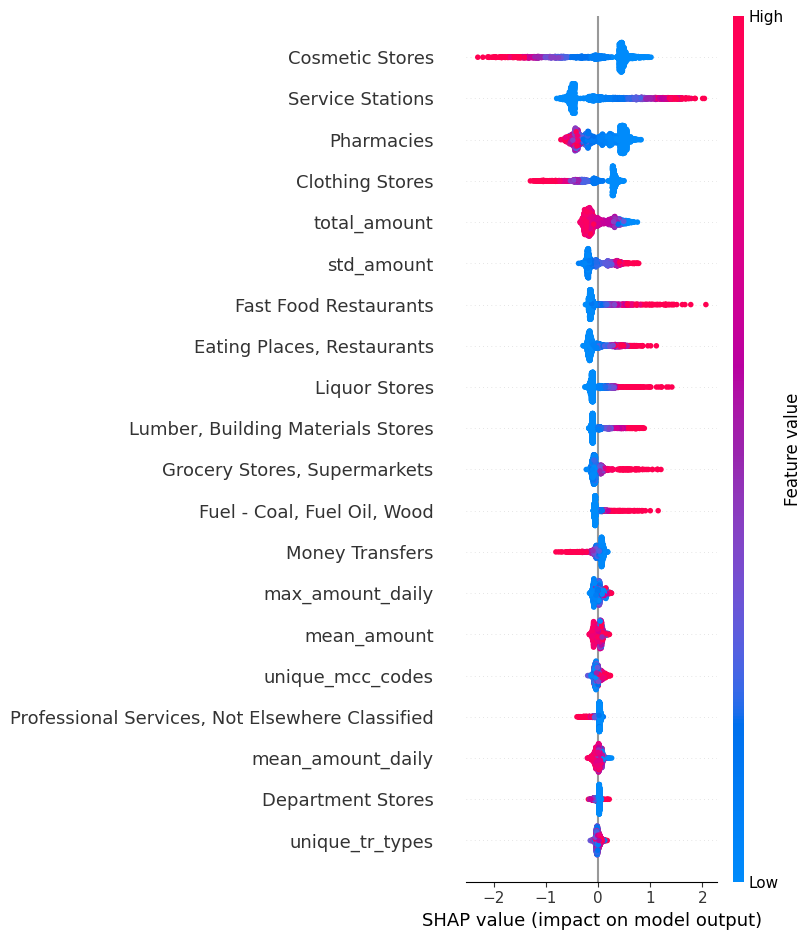

In [57]:
# Отрисовываем графики shape values
import shap
# Получаем shape values для валидационной выборки
shap_values = model.get_feature_importance(valid_pool, type="ShapValues")

# Создаем объект Explainer
explainer = shap.Explainer(model)
shap_values_valid = explainer.shap_values(X_valid)

# Отображаем графики shape values
shap.summary_plot(shap_values_valid, X_valid)


In [71]:
columns_to_drop = ['mean_amount_daily', 'max_amount_daily', 'Professional Services, Not Elsewhere Classified',
                   'unique_mcc_codes', 'Department Stores', 'unique_tr_types']

data = aggregated_data.drop(columns=columns_to_drop)

In [72]:
# Выделение тестовой выборки, где gender равен 'не определено'
test_data = data[aggregated_data['gender'] == 'не определено']

# Выделение обучающей выборки, где gender не равен 'не определено'
train_data = data[aggregated_data['gender'] != 'не определено']

# Удаление столбца 'gender' из тестовой выборки
test_data.drop('gender', axis=1, inplace=True)

#  Определение признаков и целевой переменной
X = train_data.drop(['gender'], axis=1)
y = train_data['gender']


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


In [73]:
# Разделяем тренировочные данные на обучающую и валидационную выборки
X_train, X_valid, y_train, y_valid = train_test_split(X, y, test_size=0.2, random_state=42)

# Преобразуем обучающие и валидационные данные в Pool объекты
train_pool2 = Pool(data=X_train, label=y_train, cat_features=None)
valid_pool2 = Pool(data=X_valid, label=y_valid, cat_features=None)

# Определяем параметры модели CatBoost
params = {
    'iterations': 1000,
    'learning_rate': 0.1,
    'eval_metric': 'AUC',
    'random_seed': 42,
    'logging_level': 'Silent'
}

# Обучаем модель CatBoost на обучающих данных
model2 = CatBoostClassifier(**params)
model2.fit(train_pool2, eval_set=valid_pool2, early_stopping_rounds=50)

# Предсказываем вероятности для валидационных данных
valid_pred_prob2 = model2.predict_proba(X_valid)[:, 1]
y_valid = y_valid.astype(int)
# Вычисляем ROC AUC на валидационной выборке
roc_auc2 = roc_auc_score(y_valid, valid_pred_prob2)
print(f'ROC AUC на валидационной выборке: {roc_auc2}')

ROC AUC на валидационной выборке: 0.8159838421323313


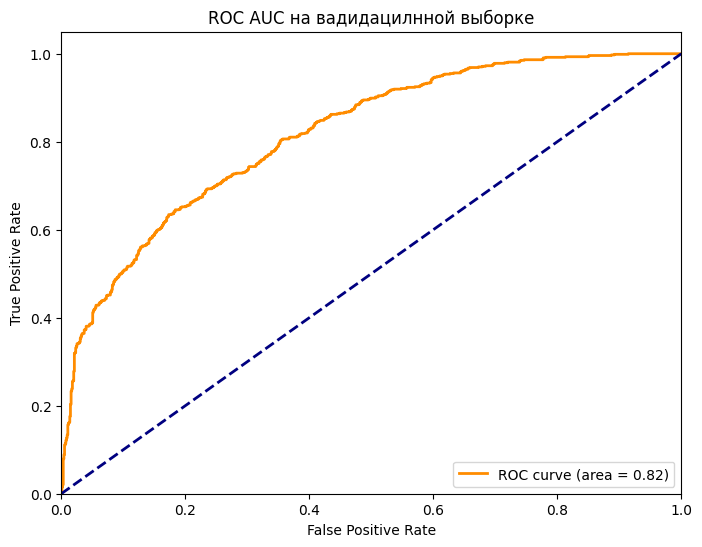

In [74]:
from sklearn.metrics import roc_curve, auc
import matplotlib.pyplot as plt

# Получаем значения fpr и tpr
fpr, tpr, _ = roc_curve(y_valid, valid_pred_prob2)
roc_auc = auc(fpr, tpr)

# Строим кривую ROC
plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, color='darkorange', lw=2, label='ROC curve (area = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC AUC на вадидацилнной выборке')
plt.legend(loc='lower right')
plt.show()


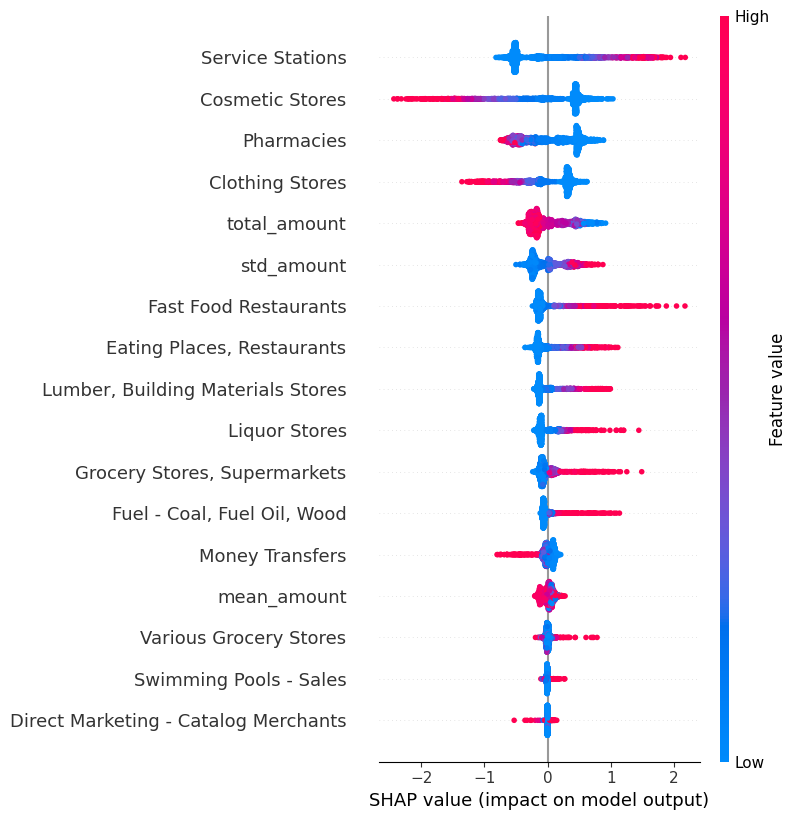

In [75]:
shap_values = model2.get_feature_importance(valid_pool2, type="ShapValues")

# Создаем объект Explainer
explainer = shap.Explainer(model2)
shap_values_valid2 = explainer.shap_values(X_valid)

# Отображаем графики shape values
shap.summary_plot(shap_values_valid2, X_valid)

In [88]:
from sklearn.model_selection import cross_val_score, StratifiedKFold

# Определяем параметры модели CatBoost
params = {
    'iterations': 1000,
    'learning_rate': 0.1,
    'eval_metric': 'AUC',
    'random_seed': 42,
    'logging_level': 'Silent'
}

# Создаем модель CatBoost
model = CatBoostClassifier(**params)

# Определяем стратегию кросс-валидации с 5 фолдами
cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
y = y.astype(int)
# Выполняем кросс-валидацию и вычисляем метрику AUC для каждого фолда
auc_scores_cv = cross_val_score(model, X, y, cv=cv, scoring='roc_auc')

# Выводим среднее значение метрики AUC по всем фолдам
print(f'Средний ROC AUC на кросс-валидации: {auc_scores_cv.mean()}')


Средний ROC AUC на кросс-валидации: 0.8001105384216531


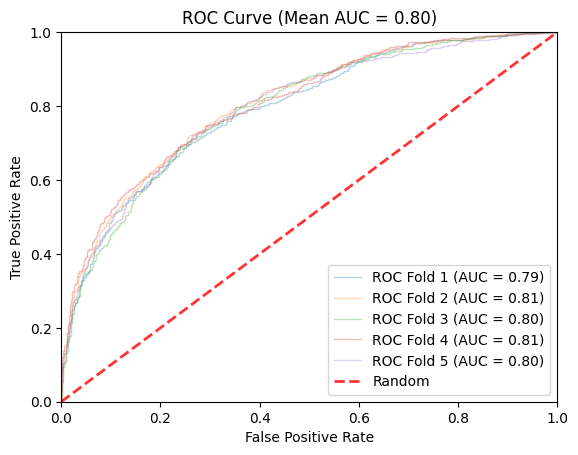

In [89]:
from sklearn.metrics import roc_curve, auc
import matplotlib.pyplot as plt

# Создаем модель CatBoost
model = CatBoostClassifier(**params)

# Инициализируем список для хранения результатов ROC-AUC для каждого фолда
roc_auc_scores = []

# Для каждого фолда выполним обучение модели, предсказание вероятностей и расчет ROC-AUC
for train_idx, test_idx in cv.split(X, y):
    X_train_fold, X_test_fold = X.iloc[train_idx], X.iloc[test_idx]
    y_train_fold, y_test_fold = y.iloc[train_idx], y.iloc[test_idx]

    # Обучаем модель на текущем фолде
    model.fit(X_train_fold, y_train_fold)

    # Получаем вероятности принадлежности к положительному классу для тестового фолда
    y_prob = model.predict_proba(X_test_fold)[:, 1]

    # Вычисляем значения FPR и TPR для построения ROC-кривой
    fpr, tpr, _ = roc_curve(y_test_fold, y_prob)

    # Вычисляем площадь под ROC-кривой для текущего фолда
    roc_auc = auc(fpr, tpr)

    # Добавляем значение ROC-AUC для текущего фолда в список
    roc_auc_scores.append(roc_auc)

    # Строим ROC-кривую для текущего фолда
    plt.plot(fpr, tpr, lw=1, alpha=0.3, label=f'ROC Fold {len(roc_auc_scores)} (AUC = {roc_auc:.2f})')

# Рассчитываем средний ROC-AUC по всем фолдам
mean_roc_auc = np.mean(roc_auc_scores)

# Строим ROC-кривую для всех фолдов
plt.plot([0, 1], [0, 1], linestyle='--', lw=2, color='r', label='Random', alpha=.8)
plt.xlim([0, 1])
plt.ylim([0, 1])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title(f'ROC Curve (Mean AUC = {mean_roc_auc:.2f})')
plt.legend(loc='lower right')
plt.show()